### [GLOBAL IMPORTS]

In [1]:
import torch
import kaggle
import pandas as pd
import numpy as np
import math

# Tabular Trees

# **[ Decision Trees ]** are :
# - Generated by recursively splitting the source data set into subsets
#    - based on attribute value test :
#         - at each node of the tree
#         - an algorithm chooses a feature and a threshold value that splits the
#           data into two child nodes
#         - the CRITERION is measured by the QUALITY of the SPLIT
#              - Gini for impurity
#              - information gain for classification
#              - variance reduction for regression
#    - completes on :
#         - a subset on a node has all the same values of the target variable
#         - or when splitting no longer adds value to the predictions
#              - STOPPING CRITERIAS hyperparameters
#                   - minimum decrease in impurity/variance threshold
#                   - maximum tree depth threshold surpassed
#                   - minimum number of samples required to make a split
#                        - @audit : EXPLAIN THIS ^
#                   - minimum number of samples required in a leaf
#                        - if a split results in a leaf having FEWER samples
#                          than this threshold, splitting stops
# - INSIGHT!
#    - As the tree GROWS with each SPLIT
#         - model predictions become more ACCURATE
#         - but it's ability to GENERALIZE decreases
#              - the risk of overfitting increases on each split
#              - this will impair models ability to perform in production on new
#                data NOT in the training set
from sklearn.tree import DecisionTreeRegressor

# **[ RandomForest ]** are:
# - An ensemble module
#    - uses multiple DecisionTree to perform regression
# - Key Difference
#    - DataSet is pre-split and segmented (bootstrapped) to each DecisionTree
#         - The sum of each bootstrap is equivalent to the original data set
#         - Effectively the BEST split is LOCALIZED to each tree and it's random
#           set of features
#              - The BEST split is no longer the result of the split amongst ALL
#                features, but amongst a RANDOM subset of features
#         - Results in a FOREST of smaller UNCORRELATED trees
#              - This can reduce the variance of the individual trees and leads
#                to an overall better model
#    - Handles the DecisionTree trade-off of ACCURACY vs GENERALIZATION
from sklearn.ensemble import RandomForestRegressor

# Fast Ai Tabular Fixes
from fastai.tabular.core import (
     TabularPandas, Categorify, FillMissing, 
     cont_cat_split, add_datepart, 
)

# Visualization lib
from sklearn.inspection import plot_partial_dependence
from fastbook import draw_tree, cluster_columns
import matplotlib.pyplot as plt
from treeinterpreter import treeinterpreter as ti
from waterfall_chart import plot as waterfall_chart
import dtreeviz

# Handles file save and loads
from pathlib import Path
import tarfile
import zipfile
from fastai.data.external import URLs
from fastai.tabular.core import (
     save_pickle, load_pickle
)

# Hacks : @audit RESOLVE ME BRO
import warnings

# This is the code from the old file_extract function in fastai.data.external. 
# See here for when it disappeared in favor of fastdownload:
# https://github.com/fastai/fastai/commit/63b624c696c956a850cc137878d2582402c1db92
def file_extract_deprecated(fname, dest=None):
     "Extract `fname` to `dest` using `tarfile` or `zipfile`."
     if dest is None: 
          dest = Path(fname).parent
     fname = str(fname)
     if   fname.endswith('gz'):  
          tarfile.open(fname, 'r:gz').extractall(dest)
     elif fname.endswith('zip'): 
          zipfile.ZipFile(fname     ).extractall(dest)
     else: 
          raise Exception(f'Unrecognized archive: {fname}')


#### Pip Installs

In [2]:
%pip install dtreeviz
%pip install kaggle
%pip install treeinterpreter
%pip install waterfallcharts

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# personal key redacted
creds = 'get-your-key-from-kaggle'

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
path = URLs.path('bluebook')
path

Path('/Users/mton/.fastai/archive/bluebook')

In [5]:
# Use Kaggle API to download dataset to that path and extract it

if not path.exists():
    path.mkdir()
    # https://www.kaggle.com/c/bluebook-for-bulldozers/rules
    # MUST accept rules else:
    # - download request will time out
    kaggle.api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract_deprecated(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

(#7) [Path('/Users/mton/.fastai/archive/bluebook/random_forest_benchmark_test.csv'),Path('/Users/mton/.fastai/archive/bluebook/Valid.csv'),Path('/Users/mton/.fastai/archive/bluebook/median_benchmark.csv'),Path('/Users/mton/.fastai/archive/bluebook/Test.csv'),Path('/Users/mton/.fastai/archive/bluebook/ValidSolution.csv'),Path('/Users/mton/.fastai/archive/bluebook/Machine_Appendix.csv'),Path('/Users/mton/.fastai/archive/bluebook/TrainAndValid.csv')]

In [6]:
# @audit : Explain why we are setting low_memory=False, by default it's TRUE
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [7]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [8]:
# Tell panda an explicit order for each categorie
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)
df['ProductSize'].unique()

[NaN, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact']
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [9]:
# The dependent variable is the most important data column
dep_var = 'SalePrice'
# running this cell repeated will apply LOG on each run!
# Only do it once! @audit : why?
df[dep_var] = np.log(df[dep_var])
df[dep_var]

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
412693     9.210340
412694     9.259131
412695     9.433484
412696     9.210340
412697     9.472705
Name: SalePrice, Length: 412698, dtype: float64

### -- Decision Trees --

In [10]:
df = add_datepart(df, 'saledate')

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [11]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [12]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [13]:
procs = [Categorify, FillMissing]

#### Difference between sets [timeseries]

- Training
- Validation
- Test

And the implications when we are dealing with a time series

In [14]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(-cond)[0]

splits = (list(train_idx), list(valid_idx))

#### Get Data

Build a Table where :
- Data are converted to NUMERIC values
- Fill in MISSING (empty) container values

In [15]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
len(to.train), len(to.valid)

(404710, 7988)

In [16]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [17]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,46,16,3,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,529,57,98,0,3,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,13,26,4,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,9,26,3,57,1,1,1,1,1,1,1.077754e+09,1,1


In [18]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [19]:
type(to)

fastai.tabular.core.TabularPandas

In [20]:
save_pickle(path/'to.pk1', to)
# to = load_pickle(path/'to.pk1') # load pk1

#### Creating the Decision Tree

In [21]:
# define our dependent and independent variable
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

# now that all our data is numeric and there are no missing values
# we can create a decision tree
m = DecisionTreeRegressor(max_leaf_nodes=4)

In [22]:
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

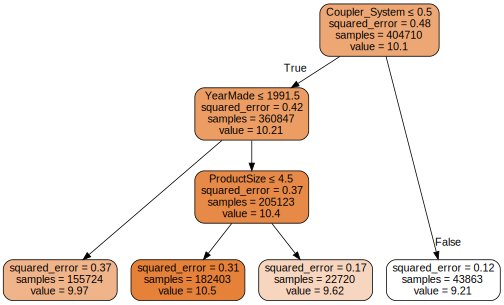

In [23]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

##### Panda DataFrame Scratchpad

In [24]:
# loc examples

# Create a DataFrame
dtf = pd.DataFrame(
    {
        # columns id :
        # - loc  = label (str)
        # - iloc = index (int)
        'A':[1, 2, 3],
        'B':[3, 4, 5],
        'C':[7, 8, 9]
    },
    # rows_id :
    # - loc  = label (str)
    # - iloc = index (int)
    index=["mt_ONE", "mt_TWO", "mt_THREE"]
)
print(dtf)

# Accessing Data
print("\nAccessing Data")
print(f"-- [mt_ONE : A] -- \n{dtf.loc['mt_ONE', 'A']}")

# Slicing Data Frame
df_slice = dtf.loc['mt_ONE':'mt_TWO', 'A':'B']
print("\nSlicing Data")
print(f"-- [mt_ONE:mt_TWO, A:B] -- \n{df_slice}")

# Boolean Indexing
b_index = dtf.loc[dtf['A']>1]
print("\nBoolean Indexing")
print(f"--[df_loc['A']>1]-- \n{b_index}")

# Modifying Data
dtf.loc['mt_ONE', 'A'] = 420 # loc  : uses row and column LABELS
dtf.iloc[1, 1] = 69          # iloc : uses row and column IDS
print(dtf)

          A  B  C
mt_ONE    1  3  7
mt_TWO    2  4  8
mt_THREE  3  5  9

Accessing Data
-- [mt_ONE : A] -- 
1

Slicing Data
-- [mt_ONE:mt_TWO, A:B] -- 
        A  B
mt_ONE  1  3
mt_TWO  2  4

Boolean Indexing
--[df_loc['A']>1]-- 
          A  B  C
mt_TWO    2  4  8
mt_THREE  3  5  9
            A   B  C
mt_ONE    420   3  7
mt_TWO      2  69  8
mt_THREE    3   5  9


##### Visualizing the Decision Tree

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


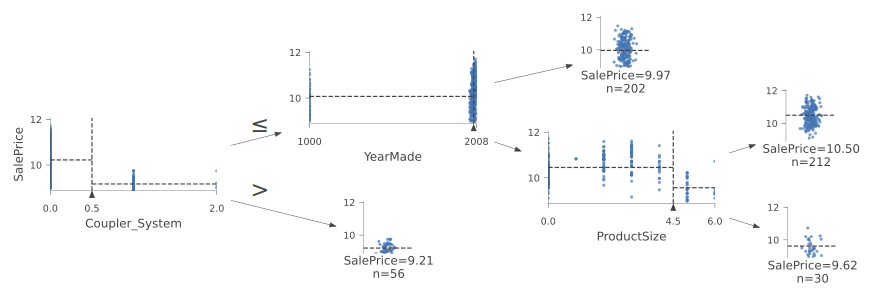

In [25]:
samp_idx = np.random.permutation(len(y))[:500]
viz_model = dtreeviz.model(
    m, 
    X_train=xs.iloc[samp_idx], 
    y_train=y.iloc[samp_idx], 
    feature_names=xs.columns, 
    target_name=dep_var,
)
viz_model.view(
    fontname='DejaVu Sans',
    scale=1.6,
    label_fontsize=10,
    orientation='LR'
)

##### Normalizing the YearMade Default Values

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


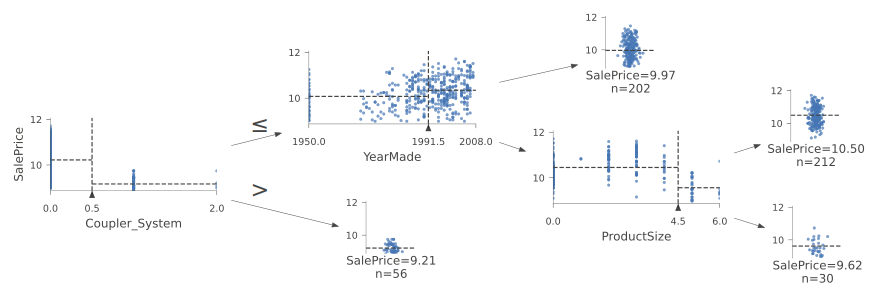

In [26]:
# Improve distribution by averaging all 1000 years to atleast 1950
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
viz_model = dtreeviz.model(
    m, 
    X_train=xs.iloc[samp_idx], 
    y_train=y.iloc[samp_idx], 
    feature_names=xs.columns, 
    target_name=dep_var
)

viz_model.view(
    fontname='DejaVu Sans',
    scale=1.6,
    label_fontsize=10,
    orientation='LR'
)

#### Full Size Decision Tree

INSIGHT!
- smaller tree generalizes
- larger tree is more accurate

HOW DO WE HANDLE THAT TRADE OFF??????

In [27]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [28]:
def r_mse(pred, y):
    return round(
        math.sqrt(
            (((pred-y)**2).mean())
        ),
        6
    )

def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

In [29]:
m_rmse(m, xs, y)

0.0

In [30]:
m_rmse(m, valid_xs, valid_y)

0.334935

In [31]:
m.get_n_leaves(), len(xs)

(324560, 404710)

In [32]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)

DecisionTreeRegressor(min_samples_leaf=25)

In [33]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248593, 0.323339)

In [34]:
m.get_n_leaves()

12397

## -- Random Forests --

- Answer to small tree generalizing vs large tree accuracy?

In [35]:
def rf(
        xs, 
        y, 
        n_estimators=40,
        max_samples=200_000,
        max_features=0.5,
        min_samples_leaf=5,
        **kwargs
    ):
    return RandomForestRegressor(
        n_jobs=-1,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=True
    ).fit(xs, y)

In [73]:
m = rf(xs, y)

In [74]:
# Much improved vs previous model trained on one massive Decision Tree
# Features include :
# - not sensitive to hyperparameter choices
#   - n_estimators can be scaled up for more accuracy : gated on training time
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170832, 0.232825)

In [75]:
# suppressing warning to NOT blow up logs
# @audit : figure out issue with : 
# - mismatch in the use of feature names between your training data (X) and the 
# model DecisionTreeRegressor during the fit phase
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    # @audit : Explain this
    preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)

0.232825

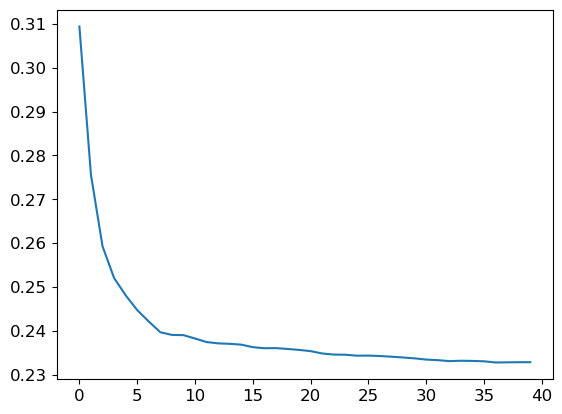

In [76]:
plt.plot(
    [
        r_mse(
            preds[:i+1].mean(0), valid_y
        ) for i in range(40)
    ]
)

### Out of Bag Error

Helps determine if : 
- we are overfitting
- the validation data happens to cover a NON overlapping time period
- mix of the ^ two

A way of measuring prediction error in a training dataset by using rows NOT
included in the training
- Essentially every tree getting it's on validation set
- Useful for small datasets - you don't need to seperate an EXPLICIT validation
set

In [77]:
# We are comparing to the training labels since this is being generated on the
# trees using the training set
# @audit : explain this ^ more clearly

# Our oob perf is much better than the validation set
# @audit : Somehow this indicates that there is additional errors beyond the 
# challenge of generalization?  THAT ISN'T CLEAR TO ME LOL
r_mse(m.oob_prediction_, y)

0.210537

## -- Model Interpretation --

Tabular data points of interest :

- How CONFIDENT are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important
FACTORS, and how did they INFLUENCE that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively REDUNDANT with each other, for purpose of
prediction?
- How do predictions vary as we vary these columns?

In [78]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    preds = np.stack(
        [
            t.predict(valid_xs) for t in m.estimators_
        ]
    )

# (trees, auctions)
# (40, 7988)
preds.shape

(40, 7988)

### Tree Variance for Prediction Confidence

Confidence in prediction can vary widely
- low standard deviation => trees agree
- high standard deviation => disagreement
    - LOW confidence and worth MANUAL INSPECTION

In [79]:
preds_std = preds.std(0)

# standard deviations for the first 5 auctions
# -- array([0.26438763, 0.10014446, 0.11290999, 0.25738921, 0.12560173])
preds_std[:5]

array([0.26988808, 0.10967743, 0.11625556, 0.27045235, 0.16733724])

### Feature Importance

In [80]:
def rf_feature_importance(m, df):
    return pd.DataFrame({
        'cols':df.columns,
        'imp':m.feature_importances_
    }).sort_values('imp', ascending=False)

fi = rf_feature_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.185999
30,Coupler_System,0.137164
6,ProductSize,0.124480
7,fiProductClassDesc,0.080666
54,ModelID,0.054499
65,saleElapsed,0.050688
3,fiSecondaryDesc,0.041103
1,fiModelDesc,0.037668
32,Hydraulics_Flow,0.035436
52,SalesID,0.026127


<AxesSubplot:ylabel='cols'>

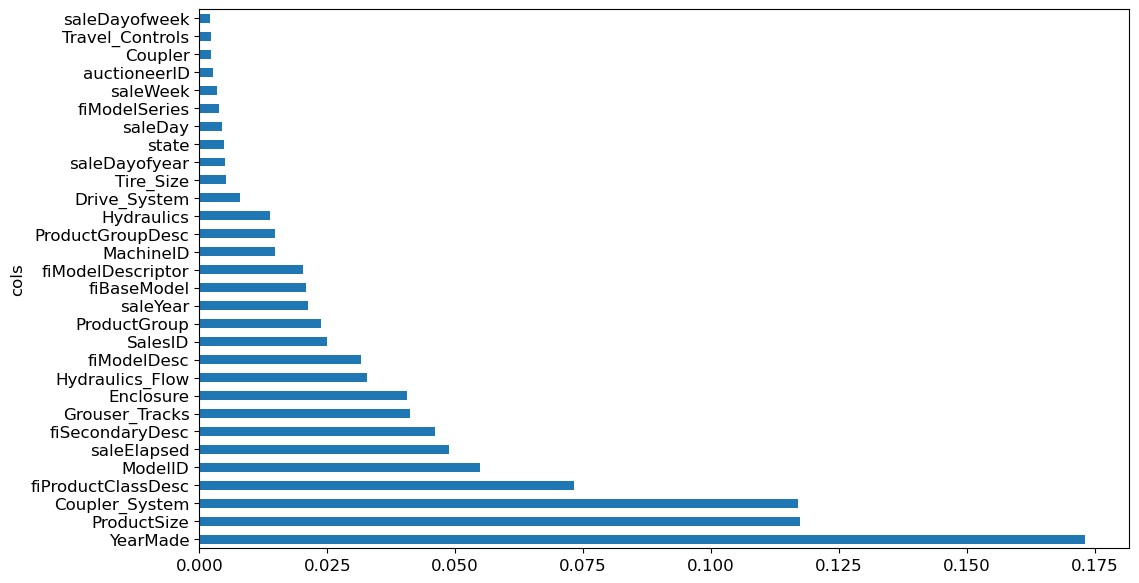

In [44]:
def plot_fi(fi):
    return fi.plot(
        'cols',
        'imp',
        'barh',
        figsize=(12, 7),
        legend=False
    )

plot_fi(fi[:30])

### Removing Low-Importance Variables

In [45]:
# Filtering out low importance variables
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [46]:
# Retrain model without low importance variables
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

In [47]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.18131, 0.230503)

In [48]:
# Our accuracy is about the same, but we have far less columns to study
# - (0.171117, 0.233947) : [66] cols -> xs
# - (0.181253, 0.232314) : [21] cols -> xs_imp
len(xs.columns), len(xs_imp.columns)

(66, 21)

<AxesSubplot:ylabel='cols'>

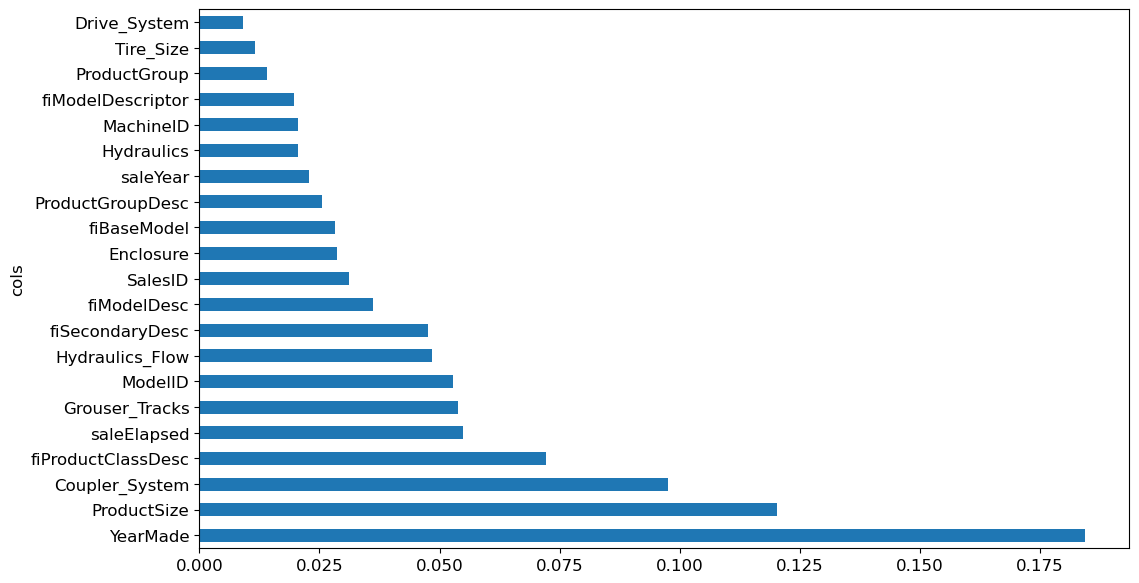

In [49]:
plot_fi(rf_feature_importance(m, xs_imp))

### Removing Redundant Variables

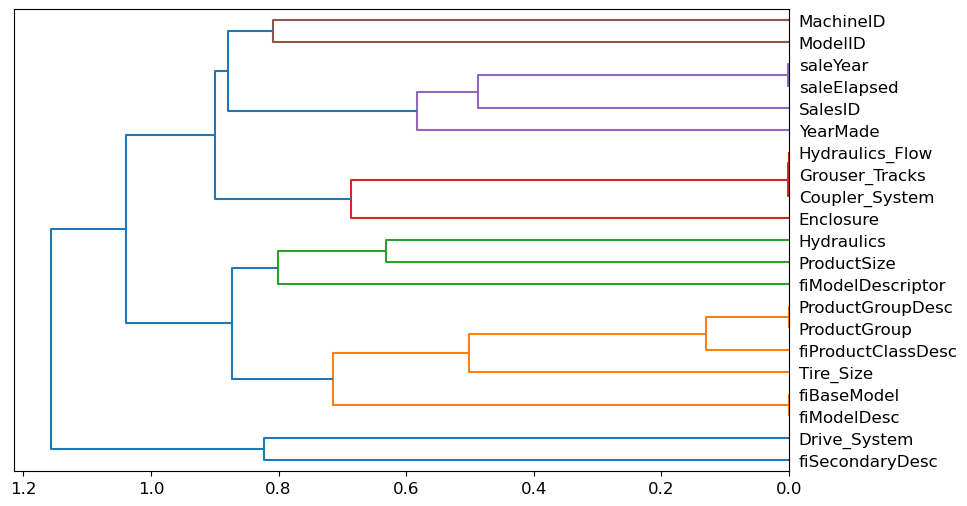

In [50]:
cluster_columns(xs_imp)

In [51]:
# redundant vars from looking at cluster graph result above ^
cg_redundant_columns = [
    'saleYear','saleElapsed',
    'Hydraulics_Flow','Grouser_Tracks','Coupler_System',
    'ProductGroupDesc','ProductGroup',
    'fiBaseModel','fiModelDesc',
]

cg_to_drop_columns = [
    'saleYear',
    'Grouser_Tracks',
    'ProductGroupDesc',
    'fiBaseModel'
]

In [52]:
def get_oob(df):
    m = RandomForestRegressor(
        n_estimators=40,
        min_samples_leaf=15,
        max_samples=50_000,
        max_features=0.5,
        n_jobs=-1,
        oob_score=True
    )
    m.fit(df, y)
    return m.oob_score_

In [53]:
# let's get our baseline
baseline = get_oob(xs_imp)
baseline

0.8781576734893485

In [54]:
# now try and remove a redundant variable one at a time
{
    c:get_oob(xs_imp.drop(c, axis=1)) for c in cg_redundant_columns
}

{'saleYear': 0.8768628311464004,
 'saleElapsed': 0.8722097904682757,
 'Hydraulics_Flow': 0.8777946405788072,
 'Grouser_Tracks': 0.877719841440727,
 'Coupler_System': 0.8770007023876663,
 'ProductGroupDesc': 0.8767569644616043,
 'ProductGroup': 0.8772189523695609,
 'fiBaseModel': 0.8764078973295162,
 'fiModelDesc': 0.8758234023013596}

In [55]:
get_oob(xs_imp.drop(cg_to_drop_columns, axis=1))

0.8750482697068109

In [56]:
xs_final = xs_imp.drop(cg_to_drop_columns, axis=1)
valid_xs_final = valid_xs_imp.drop(cg_to_drop_columns, axis=1)

# commenting out so we dont' overwrite
# save_pickle(path/'xs_final.pk1', xs_final)
# save_pickle(path/'valid_xs_final.pk1', valid_xs_final)

xs_final = load_pickle(path/'xs_final.pk1')
valid_xs_final = load_pickle(path/'valid_xs_final.pk1')

In [57]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183251, 0.232259)

### Partial Dependence

Most important predictors look to be :
- YearMade
- ProductSize

We'd like to understand the relationship between these 2

([<matplotlib.axis.YTick at 0x1696f0370>,
 [Text(0, 0, '#na#'),
  Text(0, 1, 'Large'),
  Text(0, 2, 'Large / Medium'),
  Text(0, 3, 'Medium'),
  Text(0, 4, 'Small'),
  Text(0, 5, 'Mini'),
  Text(0, 6, 'Compact')])

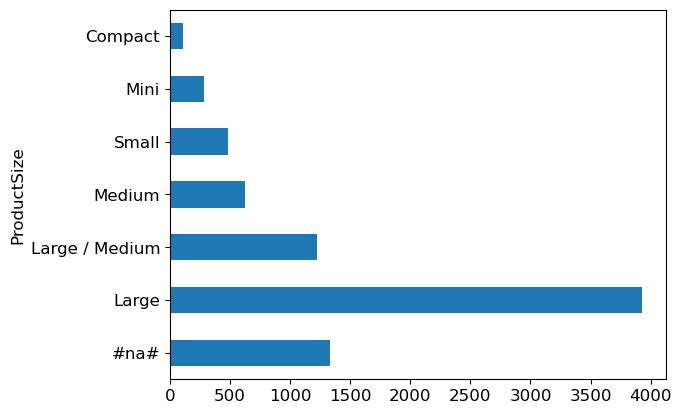

In [58]:
# Start by seeing how common each value are, check the count per categories
# @audit ... hmmm results do NOT match book!  Find out how come
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c)

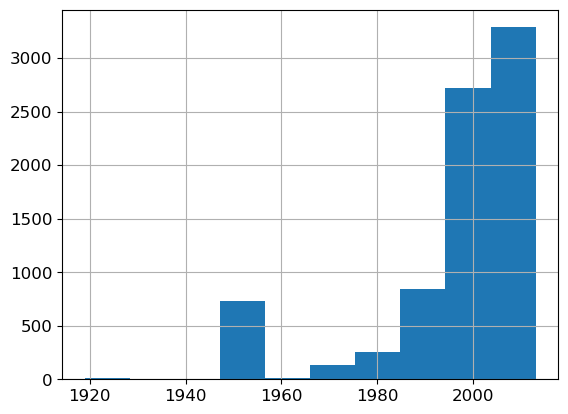

In [59]:
# For 'YearMade' we are doing a histogram
# - because it's a numeric feature
# @audit EXPLAIN WHY ^

# 1950 is used for coding missing year values, most data is after 1990
# - How certain are we about 1950 being missing year values ... what if 
# we are wrong ... @audit understand potential ISSUE
ax = valid_xs_final['YearMade'].hist()

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


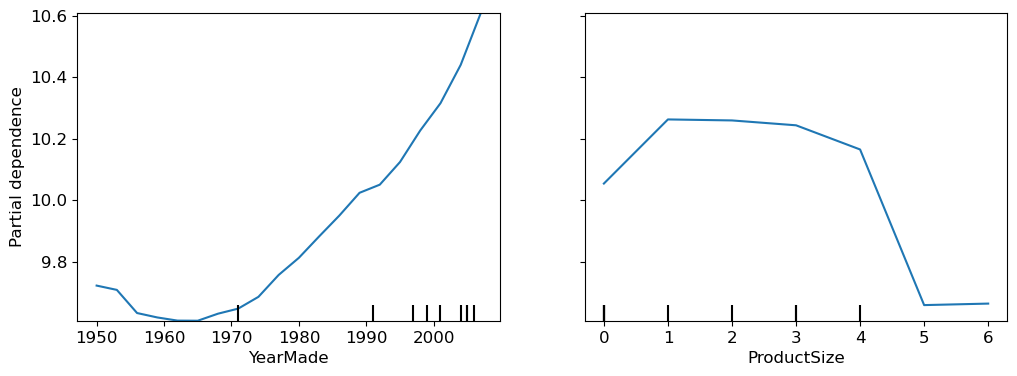

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(
    m,
    valid_xs_final,
    ['YearMade', 'ProductSize'],
    grid_resolution=20,
    ax=ax
)

### Data Leakage

Data NOT available for a predictive model
- simplest example : target as input i.e. "it rains on rainy days"

Often an artifact of :
- data collection
- aggregation
- preparation process

Sus :
- Check whether the accuracy of the model is `too GOOD to be TRUE`
    - IBM predicting customer based on web-crawl
        - returning business sites that were ALREADY customers
        - they carried IBM press release and these `keywords` were collected
- Look for `important predictors` that don't make sense in practice
    - grant model : acceptance where main feature were Sunday and Jan 1st
        - date for grant were backfilled after grant were accepted
- Look for `partial dependence` plot results that do NOT make sense
    - tractor bluebook : ProductSize flat lining (missing data)

Reinforces the notion that it's better to :

- 1 - BUILD MODEL
- 2 - DATA CLEANING

The MODEL actively helps identify how factors influence performance!


### Tree Interpreter

In [61]:
row = valid_xs_final.iloc[:5]
row

,YearMade,ProductSize,Coupler_System,fiProductClassDesc,ModelID,saleElapsed,fiSecondaryDesc,Enclosure,Hydraulics_Flow,fiModelDesc,SalesID,ProductGroup,fiModelDescriptor,MachineID,Hydraulics,Drive_System,Tire_Size
22915,1950,3,0,48,4124,1.317600e+09,43,1,0,2301,1218822,5,0,1024652,1,0,0
22916,2006,0,0,2,24808,1.317859e+09,50,6,0,278,1218823,1,17,1067601,0,2,0
22917,2006,0,2,41,9580,1.317859e+09,0,6,3,4514,1218824,3,0,1010582,4,0,0
22918,2003,0,2,44,6270,1.317859e+09,0,6,3,4213,1218825,3,0,1026609,4,0,0
22919,2007,0,0,1,17976,1.317859e+09,21,6,0,4647,1218826,1,0,1032638,0,2,0


In [62]:
prediction, bias, contributions = ti.predict(
    m,
    row.values
)

In [63]:
prediction[0], bias[0], contributions[0].sum()

(array([9.94708073]), 10.104746057831763, -0.15766532528651994)

<module 'matplotlib.pyplot' from '/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/matplotlib/pyplot.py'>

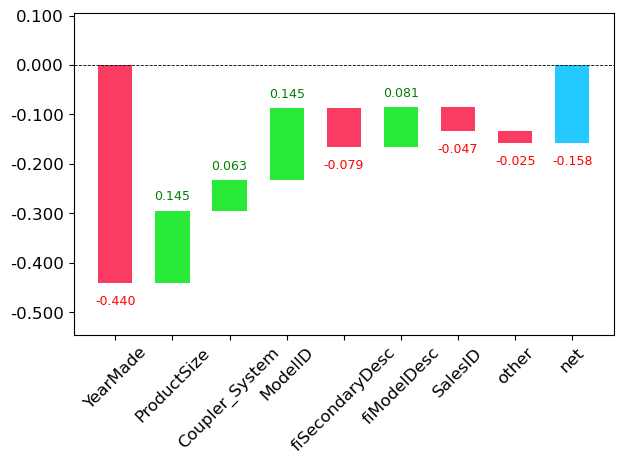

In [64]:
waterfall_chart(
    valid_xs_final.columns, 
    contributions[0],
    threshold=0.08,
    rotation_value=45,
    formatting='{:,.3f}'
)

## -- Extrapolation and Neural Networks --

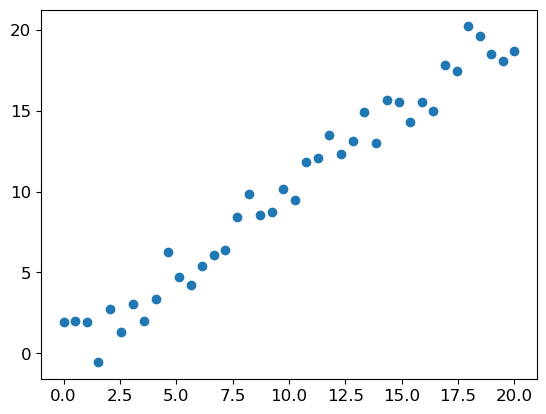

In [65]:
# The extrapolation problem
x_lin = torch.linspace(0, 20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin)

In [66]:
xs_lin = x_lin.unsqueeze(1)
xs_lin.shape, x_lin.shape

(torch.Size([40, 1]), torch.Size([40]))

In [67]:
x_lin[:,None].shape

torch.Size([40, 1])

In [68]:
m_lin = RandomForestRegressor().fit(
    xs_lin[:30],
    y_lin[:30]
)

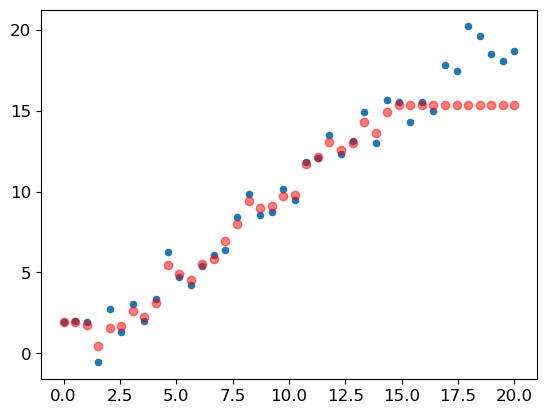

In [69]:
plt.scatter(
    x_lin, 
    y_lin, 
    20
)
plt.scatter(
    x_lin, 
    m_lin.predict(xs_lin), 
    color='red', 
    alpha=0.5
)

### Finding Out of Domain Data

In [81]:
df_dom = pd.concat([
    xs_final,
    valid_xs_final
])

is_valid = np.array(
    [0]*len(xs_final) + [1]*len(valid_xs_final)
)

m = rf(df_dom, is_valid)
rf_feature_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.883212
10,SalesID,0.086833
13,MachineID,0.024483
0,YearMade,0.001042
4,ModelID,0.001026
9,fiModelDesc,0.000628
